<a href="https://colab.research.google.com/github/wander-asb/MRI_CLASSIFICATION/blob/main/A_new_deep_CNN_for_Brain_tumor_classification(Multi).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Detection and Classifiaction Using CNN Algorithm and Deep Learning Techniques
> Bloco com recuo



## Importação e leitura da base de dados

In [127]:
import torch
import os
import shutil
import pandas              as pd
import numpy               as np
import torch.nn.functional as F
import cv2                 as cv 
from skimage                 import io
from google.colab            import drive
from google.colab.patches    import cv2_imshow
from torch                   import nn, optim
from torchvision             import datasets, transforms
from sklearn.model_selection import train_test_split

In [128]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [129]:
#Leitura do path
test_dir = "/content/gdrive/MyDrive/MRI_TUMOR_CNN/DadosClassificacaoTumor/Testing"
train_dir = "/content/gdrive/MyDrive/MRI_TUMOR_CNN/DadosClassificacaoTumor/Training"

In [130]:
train_shape = datasets.ImageFolder(root = train_dir)

test_shape = datasets.ImageFolder(root = test_dir)
print(train_shape, '\n'*2, test_shape)

Dataset ImageFolder
    Number of datapoints: 2870
    Root location: /content/gdrive/MyDrive/MRI_TUMOR_CNN/DadosClassificacaoTumor/Training 

 Dataset ImageFolder
    Number of datapoints: 394
    Root location: /content/gdrive/MyDrive/MRI_TUMOR_CNN/DadosClassificacaoTumor/Testing


## Tratamento e modelagem da base de dados

In [131]:
transform_train = transforms.Compose(
    [
     transforms.Resize([128,128]),
        transforms.ToTensor()
    ]
)

transform_test = transforms.Compose(
    [
     transforms.Resize([128,128]),
     transforms.ToTensor()
    ]
)

In [132]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

In [133]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=12, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True)

In [134]:
input = train_dataset[0][0][0].view(32, -1).size()[1]

## Arquitetura da Rede Neural Convolucional (CNN)

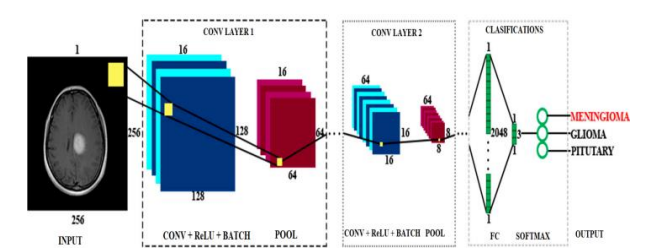

In [135]:
url = '/content/gdrive/MyDrive/MRI_TUMOR_CNN/Images/figure07.png'
img = io.imread(url)
cv2_imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [136]:
class classificador(nn.Module):
    def __init__ (self):
        super().__init__()
      
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=(1,1))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=(1,1))

        self.activation = nn.ReLU() 
        self.bnorm1 = nn.BatchNorm2d(num_features=16)
        self.bnorm2 = nn.BatchNorm2d(num_features=64)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        
        self.flatten = nn.Flatten()
        
        #input = train_dataset[0][0][0].view(32, -1).size()[1]

        self.linear1 = nn.Linear(in_features=57600, out_features=256)
        self.linear2 = nn.Linear(in_features=256, out_features=128)
        self.output = nn.Linear(in_features=128, out_features=4)
        
    def forward(self, X):
        X = self.pool(self.bnorm1(self.activation(self.conv1(X))))
        X = self.pool(self.bnorm2(self.activation(self.conv2(X))))
        X = self.flatten(X)
        
        X = self.activation(self.linear1(X))
        X = self.activation(self.linear2(X))
        X = self.output(X)
        
        return X

## Seta a GPU para usabilidade da nossa CNN

In [137]:
net = classificador()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [138]:
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
print(device)

net.to(device)

cuda


classificador(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=57600, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=4, bias=True)
)

## Arquitetura do loop de treinamento da CNN

In [139]:
def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.
    for i, data in enumerate(loader):
        
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        ps = F.softmax(outputs, dim=1)
        top_p, top_class = ps.topk(k=1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        
        accuracy= torch.mean(equals.type(torch.float))
        
        running_accuracy += accuracy
        
        #Imprimir os dados referentes a este loop
        print("Época {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}".format(epoch + 1, i+1, len(loader)\
                                                                                             , loss, accuracy), end= '\r')
    #Impressão referente à épocas
    print("Época {:3d} Finalizada: perda {:.5f} - precisão {:.5f}".format(epoch+1, running_loss/len(loader)\
                                                                         ,running_accuracy/len(loader)))

In [140]:
for epoch in range(10):
    print("Treinando...")
    training_loop(train_loader, epoch)
    net.eval()
    print('Validando...')
    training_loop(test_loader, epoch)
    net.train()

Treinando...
Época   1 Finalizada: perda 0.96957 - precisão 0.71181
Validando...
Época   1 Finalizada: perda 1.26504 - precisão 0.55606
Treinando...
Época   2 Finalizada: perda 0.36866 - precisão 0.86042
Validando...
Época   2 Finalizada: perda 0.73229 - precisão 0.75202
Treinando...
Época   3 Finalizada: perda 0.17823 - precisão 0.93750
Validando...
Época   3 Finalizada: perda 0.56460 - precisão 0.82525
Treinando...
Época   4 Finalizada: perda 0.12500 - precisão 0.95556
Validando...
Época   4 Finalizada: perda 0.29043 - precisão 0.92677
Treinando...
Época   5 Finalizada: perda 0.06869 - precisão 0.97708
Validando...
Época   5 Finalizada: perda 0.38549 - precisão 0.88586
Treinando...
Época   6 Finalizada: perda 0.04221 - precisão 0.98646
Validando...
Época   6 Finalizada: perda 0.27093 - precisão 0.93182
Treinando...
Época   7 Finalizada: perda 0.09178 - precisão 0.97118
Validando...
Época   7 Finalizada: perda 0.20590 - precisão 0.93687
Treinando...
Época   8 Finalizada: perda 0.09389